In [1]:
import warnings
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
from fcn import FCN
from loss import SegmentationLoss
from dataset import SegmentationDataset
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from utils import calculate_metrics, map_one_hot_to_image
from PIL import Image
import tqdm

2024-08-16 22:17:33.311399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 22:17:33.553428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 22:17:33.606401: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 22:17:34.017236: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 22:17:40.417852: W tensorflow/compiler/tf2

In [2]:
# Hyperparameters
num_classes = 10  # 9 classes + background
batch_size = 1
learning_rate = 0.1
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load the dataset
train_dataset = SegmentationDataset(data_dir="./fcn_data")
train_loader = DataLoader(train_dataset, batch_size=batch_size)
# Initialize model
# model = FCN(3, num_classes).to(device)  # FCN expects 3-channel input images

In [4]:
# Color map for converting RGB masks to class indices
color_map = {
    0: [0, 0, 0],
    1: [25, 82, 255],
    2: [255, 25, 197],
    3: [140, 255, 25],
    4: [226, 255, 25],
    5: [255, 197, 25],
    6: [140, 25, 255],
    7: [54, 255, 25],
    8: [25, 255, 82],
    9: [255, 111, 25],
}
color_map_list = [
    [0, 0, 0],
    [25, 82, 255],
    [255, 25, 197],
    [140, 255, 25],
    [226, 255, 25],
    [255, 197, 25],
    [140, 25, 255],
    [54, 255, 25],
    [25, 255, 82],
    [255, 111, 25],
]
# color_map = {
#     0: [0, 0, 0],  # Black
#     1: [255, 0, 0],  # Red
#     2: [0, 255, 0],  # Green
#     3: [0, 0, 255],  # Blue
#     4: [255, 255, 0],  # Yellow
#     5: [255, 0, 255],  # Magenta
#     6: [0, 255, 255],  # Cyan
#     7: [128, 0, 128],  # Purple
#     8: [255, 165, 0],  # Orange
#     9: [0, 128, 128],  # Teal
# }


def convert_rgb_to_class_index(mask, color_map=color_map):
    h, w, c = mask.shape
    mask_out = np.zeros((h, w), dtype=np.uint8)
    for class_idx, color in color_map.items():
        color = np.array(color)
        class_mask = np.all(mask == color, axis=-1)
        mask_out[class_mask] = class_idx
    return mask_out


def preprocess_batch_images(images):
    # Keep only the first 3 channels
    images = images[:, :, :, :3]
    images = images.to(device)
    images = images.float()  # Convert to float for division
    images /= 255.0
    # Permute to (batch_size, channels, height, width)
    images = images.permute(0, 3, 1, 2)
    # Resize images to (640, 640)
    images = F.interpolate(
        images, size=(640, 640), mode="bilinear", align_corners=False
    )
    images = images.permute(0, 2, 3, 1)

    return images


def preprocess_batch_masks(masks):
    # Keep only the first 3 channels
    masks = masks.float()
    masks = masks[:, :, :, :3]

    # Permute to (batch_size, channels, height, width)
    masks = masks.permute(0, 3, 1, 2)
    # Resize masks to (640, 640)
    masks = F.interpolate(masks, size=(640, 640), mode="nearest")

    # Convert RGB masks to class indices
    masks_out = [
        torch.from_numpy(
            convert_rgb_to_class_index(mask.permute(1, 2, 0).cpu().numpy())
        ).long()
        for mask in masks
    ]
    masks_out = torch.stack(masks_out).to(device)

    # Convert class indices to one-hot encoding
    masks_one_hot = (
        F.one_hot(masks_out, num_classes=num_classes).permute(0, 3, 1, 2).float()
    )
    masks = masks / 255.0

    return masks_one_hot, masks.permute(0, 2, 3, 1)


def convert_index_to_image(index, color_map):
    """
    Converts a batch of class probability tensors to images.

    Args:
        index: A torch tensor of shape [batch_size, num_classes, height, width] with class probabilities.
        color_map: A dictionary mapping class indices to color values.

    Returns:
        A torch tensor of shape [batch_size, height, width, 3] representing the images.
    """

    # Take the argmax over the class dimension (axis=1)
    max_class = torch.argmax(index, dim=1)  # Shape [batch_size, height, width]

    # Initialize an output image tensor with the same batch size, height, and width, but with 3 channels for RGB
    batch_size, height, width = max_class.shape
    output_image = torch.zeros((batch_size, height, width, 3), dtype=torch.uint8)

    # Vectorized mapping of class indices to RGB colors for each image in the batch
    for class_idx, color in color_map.items():
        output_image[max_class == class_idx] = torch.tensor(color, dtype=torch.uint8)

    return output_image

In [9]:
model = torch.load("../bestModels/fcn.pt", map_location=torch.device("cpu"))

torch.Size([1, 10, 640, 640])
torch.Size([1, 10, 640, 640])


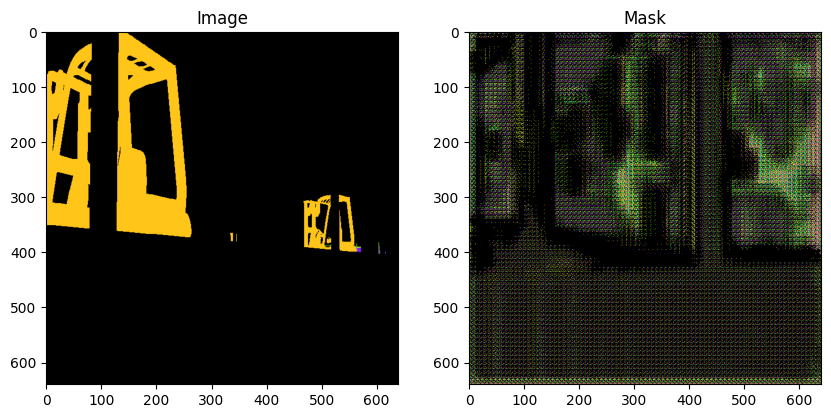

In [19]:
for i, (images, masks) in enumerate(train_loader):
    images = images.to(device)
    # images = images.float()  # Convert to float for division
    # images /= 255.0  # Normalize pixel values to [0, 1]
    images = preprocess_batch_images(images)
    index, masks = preprocess_batch_masks(masks)
    print(index.shape)

    outputs = model(images)
    outputsRgb = convert_index_to_image(outputs, color_map=color_map)
    print(outputs.shape)

    # print(masks.shape)
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(10, 5)
    )  # Adjust figsize as needed
    # Image plot
    axes[0].imshow(masks[0].cpu().numpy())  # Assuming RGB image
    axes[0].set_title("Image")

    # Mask plot
    axes[1].imshow(outputsRgb[0].detach().cpu().numpy())  # Assuming grayscale mask
    axes[1].set_title("Mask")

    plt.show()
    break

In [6]:
model = torch.load("./bestModelFinal.pt", map_location=torch.device("cpu"))

torch.Size([1, 10, 640, 640])
torch.Size([1, 10, 640, 640])


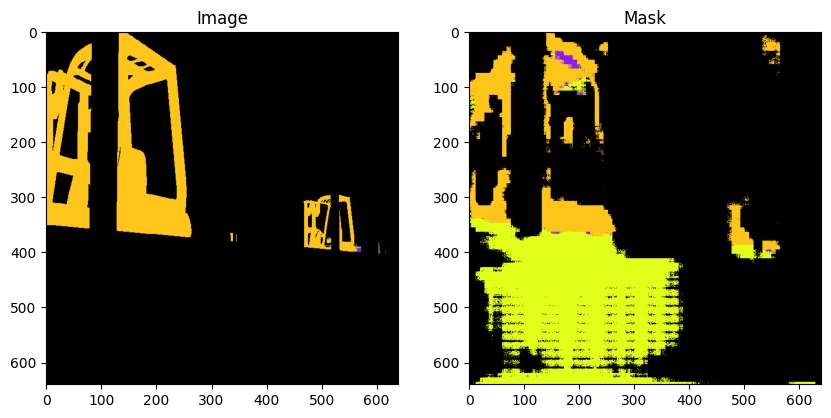

In [7]:
for i, (images, masks) in enumerate(train_loader):
    images = images.to(device)
    # images = images.float()  # Convert to float for division
    # images /= 255.0  # Normalize pixel values to [0, 1]
    images = preprocess_batch_images(images)
    index, masks = preprocess_batch_masks(masks)
    print(index.shape)
    maskss = convert_index_to_image(index, color_map=color_map)

    outputs = model(images)
    outputsRgb = convert_index_to_image(outputs, color_map=color_map)
    print(outputs.shape)

    # print(masks.shape)
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(10, 5)
    )  # Adjust figsize as needed
    # Image plot
    axes[0].imshow(maskss[0].cpu().numpy())  # Assuming RGB image
    axes[0].set_title("Image")

    # Mask plot
    axes[1].imshow(outputsRgb[0].detach().cpu().numpy())  # Assuming grayscale mask
    axes[1].set_title("Mask")

    plt.show()
    break

In [10]:
index.shape

torch.Size([1, 10, 640, 640])

In [11]:
imagess = convert_index_to_image(index, color_map=color_map)

In [12]:
imagess.shape

torch.Size([1, 640, 640, 3])

In [13]:
index[0, :, 600, 100]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
imagess = imagess[0].numpy() / 255

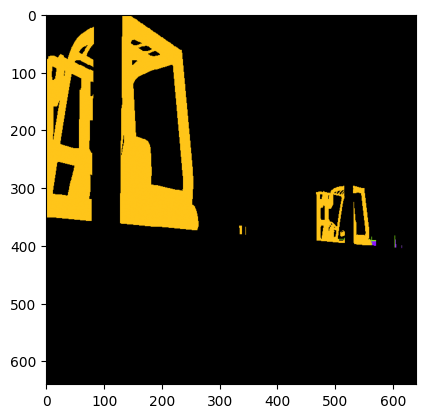

In [15]:
plt.imshow(imagess)